In [1]:
import xarray as xr
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator
import cmocean

In [2]:
root = "ipfs://QmfAzqPtR99owGURk27JV4Vgwun1CxRpKjomtkBxYufv5b"
dset_meteo = xr.open_dataset(f"{root}/DShip.zarr",engine="zarr")
dset_ctd = xr.open_dataset(f"{root}/CTD.zarr",engine="zarr")

root_radio = 'ipfs://QmSUUUPcGcpwdJJCVDGPGYksLsqkWbfh6d6xFcTk2Qu7Zf'
dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")
dset_rad_meteor= dset_radio.where((dset_radio.platform=='RV_Meteor') & (dset_radio.ascent_flag==0),drop=True)

In [3]:
dset_ctd_new = dset_ctd.assign_coords({'SOUNDING':dset_ctd.TIME.values}) 

In [4]:
with open("/Users/hans/Documents/bow_tie/actionlog_book/stations_bowtie_ctd.yaml", 'r') as stream:
    dic_ctd = yaml.safe_load(stream)
stations = pd.DataFrame(dic_ctd['stations'])

In [5]:
dset_ctd_sel = dset_ctd_new.sel(SOUNDING=slice('2024-08-31 12','2024-09-06 23'),PRES=slice(0,100))
dset_radio_sel = dset_rad_meteor.sel(launch_time=slice('2024-08-31 12','2024-09-06 23'),alt=slice(0,1000))

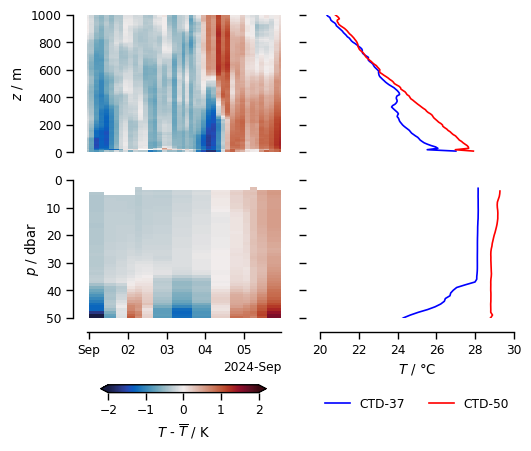

In [7]:
sns.set_context("paper")
fig = plt.figure(figsize=(14/2.54,10/2.54),facecolor='white')
ax1=fig.add_axes([0.15,-0.08,0.3,0.02])
ax= fig.add_subplot(221)
(dset_radio_sel.ta - dset_radio_sel.ta.mean('launch_time')).rolling(
    launch_time=3,center=True).mean().plot(
    x='launch_time',
    vmin=-2,vmax=2,
    cmap=cmocean.cm.balance,
    add_colorbar=False)

ax.set_xlim([dset_radio_sel.launch_time.sel(launch_time='2024-09-01 00:00:00',method='nearest'),
            dset_radio_sel.launch_time.sel(launch_time='2024-09-06 00:00:00',method='nearest')])
sns.despine(offset=10,ax=ax)
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylim([0,1000])
ax.set_ylabel(r'$z$ / m')

ax= fig.add_subplot(223)
plot_cb = (dset_ctd_sel.TEMP - dset_ctd_sel.TEMP.mean('SOUNDING')).rolling(SOUNDING=3,center=True).mean().plot(
    x='SOUNDING',
    vmin=-2,vmax=2,
    cmap=cmocean.cm.balance,
    add_colorbar=False)
ax.set_ylim([50,0])
ax.set_xlim([dset_radio_sel.launch_time.sel(launch_time='2024-09-01 00:00:00',method='nearest'),
            dset_radio_sel.launch_time.sel(launch_time='2024-09-06 00:00:00',method='nearest')])
sns.despine(offset=10,ax=ax)
ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.set_ylabel(r'$p$ / dbar')
ax.set_xlabel(None)

b1 = plt.colorbar(plot_cb,
                  extend='both',
                  orientation='horizontal',
                  cax=ax1,shrink=0.8,pad=0.09)
b1.ax.set_xlabel(r"$T$ - $\overline{T}$ / K");

ax= fig.add_subplot(222)
(dset_radio_sel.ta-273.15).sel(launch_time=slice(stations['start'].loc[stations['station_id']=='CTD-37'].values[0],
                         stations['end'].loc[stations['station_id']=='CTD-37'].values[0])).plot(
    y='alt',color='b'
            )

(dset_radio_sel.ta-273.15).sel(launch_time=slice(stations['start'].loc[stations['station_id']=='CTD-50'].values[0],
                         stations['end'].loc[stations['station_id']=='CTD-50'].values[0])).plot(
    y='alt',color='r'
            )

ax.set_title(None)
sns.despine(offset=10,ax=ax)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_ylim([0,1000])
ax.set_xlim([20,30])
ax.spines[['bottom','left']].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_yticklabels({})

ax= fig.add_subplot(224)
dset_ctd_sel.TEMP.sel(SOUNDING=slice(stations['start'].loc[stations['station_id']=='CTD-37'].values[0],
                         stations['end'].loc[stations['station_id']=='CTD-37'].values[0])).plot(
    y='PRES',color='b',label='CTD-37'
    )

dset_ctd_sel.TEMP.sel(SOUNDING=slice(stations['start'].loc[stations['station_id']=='CTD-50'].values[0],
                         stations['end'].loc[stations['station_id']=='CTD-50'].values[0])).plot(
    y='PRES',color='r',label='CTD-50'
    )
ax.set_title(None)
ax.set_ylabel(None)
ax.set_title(None)
sns.despine(offset=10,ax=ax)
ax.set_ylim([50,0])
ax.set_xlim([20,30])
ax.set_yticklabels({});
ax.spines[['left']].set_visible(False)
ax.set_xlabel(r'$T$ / $\degree$C')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          ncol=2,frameon=False)

plt.savefig('../figures/temp_air_sea_ctd.pdf',
            format='pdf',bbox_inches='tight',orientation={'landscape'})